# 环境说明

In [1]:
!python -V

Python 3.11.5


In [18]:
import sklearn
import pandas
import statsmodels
import matplotlib

In [3]:
sklearn.__version__

'1.5.2'

In [4]:
pandas.__version__

'2.1.1'

In [8]:
statsmodels.__version__

'0.14.4'

In [20]:
matplotlib.__version__

'3.8.0'

# 代码实现

In [5]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [6]:
df = pd.read_csv("data/train.csv")

In [7]:
df.head()

,Age,Blood_Sugar,Blood_Pressure,Weight,Heart_Disease
0,58,99.975461,106.328124,62.448684,0
1,71,93.609515,134.190672,67.875853,0
2,48,119.131949,115.773278,49.263101,0
3,34,98.626509,117.651983,93.111787,0
4,62,114.056088,119.456831,71.043221,0


In [8]:
label_name = 'Heart_Disease'

In [9]:
X = df.drop(label_name, axis=1)
y = df[label_name]

# 回归结果

## Stasmodels

In [10]:
# 添加常数列（截距项）到特征中
X_ = sm.add_constant(X)

# 拟合逻辑回归模型
model = sm.Logit(y, X_)
result = model.fit()

# 输出模型摘要
print(result.summary())

# 进行预测（概率值）
y_pred_prob = result.predict(X_)
# 将概率值转化为0/1预测类别，使用阈值0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)
# 计算准确率
accuracy = accuracy_score(y, y_pred_class)
print(f"准确率: {accuracy:.4f}")

# 计算AUC（曲线下面积）
auc = roc_auc_score(y, y_pred_prob)
print(f"AUC: {auc:.4f}")

Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:          Heart_Disease   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.8405
Time:                        14:56:44   Log-Likelihood:                -22.594
converged:                       True   LL-Null:                       -141.63
Covariance Type:            nonrobust   LLR p-value:                 2.421e-50
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -109.6707     24.800     -4.422      0.000    -158.278     -61.064
Age             

## 参数解析

In [11]:
coef = result.params
coef.index = ['intercept' if i=='const' else i for i in coef.index ]
coef['threshold'] = None

In [12]:
param_df = pd.concat([coef, X.min(), X.max()], axis=1)
param_df.columns = ['coef', 'min', 'max']
param_df['type'] = 'continuous'
param_df['position'] = None
param_df = param_df.reset_index()
param_df = param_df.rename(columns={'index': 'feature'})

In [13]:
param_df

,feature,coef,min,max,type,position
0,intercept,-109.670720,NaN,NaN,continuous,None
1,Age,0.495327,20.000000,79.000000,continuous,None
2,Blood_Sugar,0.555763,58.230465,147.510575,continuous,None
3,Blood_Pressure,0.013473,52.263725,189.917556,continuous,None
4,Weight,0.064694,19.907497,110.265186,continuous,None
5,threshold,NaN,NaN,NaN,continuous,None


## 绘图函数

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import gridspec
from matplotlib.transforms import (Bbox, TransformedBbox)
from mpl_toolkits.axes_grid1.inset_locator import (BboxConnector)


def adj_range(orig_left, orig_right):
    orig_range = orig_right - orig_left
    tick_scale = np.floor(np.log10(orig_range / 10))  
    if tick_scale != 0: 
        quantile_num = orig_range / 10  
        tick_ratio = quantile_num // (10 ** tick_scale)  
        real_tick = tick_ratio * 10 ** tick_scale  
    else:  
        if orig_range // 10 >= 8: 
            real_tick = 10 
        elif orig_range // 5 >= 8: 
            real_tick = 5 
        else:
            real_tick = 2  # 否则为2
    adj_right = np.ceil(orig_right / real_tick) * real_tick  # 调整后的右区间
    adj_left = np.floor(orig_left / real_tick) * real_tick  # 调整后的左区间
    return adj_left, adj_right, real_tick

### return df, intercept, threshold from the excel
def generate_df_rank(df, first_point=100):
    df.index = df["feature"].values
    intercept = df.loc["intercept", "coef"]
    threshold = df.loc["threshold", "coef"]
    df = df.drop(index=["intercept", "threshold"])
    df = df.reset_index()
    df["sequence"] = list(range(0, df.shape[0]))
    for i in df.index:
        adj_left, adj_right, _ = adj_range(df.loc[i, 'min'], df.loc[i, 'max'])
        df.loc[i, 'min'], df.loc[i, 'max'] = adj_left, adj_right
    df["range*coef"] = df["coef"] * (df["max"] - df["min"])
    df["abs_range*coef"] = abs(df["range*coef"])
    df = df.sort_values(by="abs_range*coef", ascending=False)
    point = first_point * df["abs_range*coef"] / df["abs_range*coef"].iloc[0]
    df["point"] = point
    df["negative_coef"] = np.minimum(df["coef"], 0)
    df["positive_coef"] = np.maximum(df["coef"], 0)
    df = df.sort_values(by="sequence", ascending=True)
    return df, intercept, threshold


def compute_x(df, lm_intercept, first_point, maxi_point, mini_point=0):
    maxi_score = sum(df["negative_coef"] * df["min"]) + sum(df["positive_coef"] * df["max"]) + lm_intercept
    mini_score = sum(df["negative_coef"] * df["max"]) + sum(df["positive_coef"] * df["min"]) + lm_intercept
    coef = (maxi_score - mini_score) / maxi_point  
    precision = 500 
    point_interval = np.linspace(mini_point, maxi_point, precision) 
    score_interval = point_interval * coef + mini_score
    prob_interval = 1 / (1 + np.exp(-score_interval))
    xtick_interval = np.linspace(0, 1, precision)  
    return mini_point, maxi_point, xtick_interval, prob_interval, point_interval

def set_axis(ax, title, min_point, max_point, xticks, xticklabels, position, first_point, type_,
             ax_para={"c": "black", "linewidth": 1, "linestyle": "-"},
             xtick_para={"fontsize": 8, "fontfamily": "Times New Roman",
                         "fontweight": "bold"},
             ylabel_para={"fontsize": 10, "fontname": "SimHei", "labelpad": 140,
                          "loc": "center", "color": "black", "rotation": "horizontal"}, is_prob=False):
    ax.set_xlim(0, 1.1)
    if not is_prob:
        ax.axhline(0.6, xmin=(min_point / first_point + 0.02) / 1.1,
                   xmax=(max_point / first_point + 0.02) / 1.1, **ax_para)
    else: 
        ax.axhline(0.6, xmin=(min_point + 0.02) / 1.1,
                   xmax=(max_point + 0.02) / 1.1, **ax_para)
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines['top'].set_visible(False)
    for i in range(0, len(xticks)):
        ax.axvline(xticks[i] + 0.02, ymin=0.6 - 0.2, ymax=0.6, **ax_para)
        if position[i] == "up":
            ax.annotate(xticklabels[i], xy=(xticks[i] + 0.02, 0.75), horizontalalignment="center",
                        **xtick_para)
        else:
            ax.annotate(xticklabels[i], xy=(xticks[i] + 0.02, 0), horizontalalignment="center",
                        **xtick_para)
        if i == len(xticks) - 1:
            continue
        if type_ != 'continuous':
            continue
        if not is_prob:
            if abs(xticks[i + 1] - xticks[i]) > 0.07:
                for j in np.linspace(xticks[i], xticks[i + 1], 6):
                    ax.axvline(j + 0.02, ymin=0.6 - 0.1, ymax=0.6, **ax_para)
            elif abs(xticks[i + 1] - xticks[i]) > 0.025:
                for j in np.linspace(xticks[i], xticks[i + 1], 3):
                    ax.axvline(j + 0.02, ymin=0.6 - 0.1, ymax=0.6, **ax_para)
    ax.set_ylabel(title, **ylabel_para)


def grid_connect(ax1, ax2, xticks,
                 prop_lines={"lw": 0, "color": "black", "linestyle": "-"}, **kwargs):
    for xtick in xticks:
        bbox = Bbox.from_extents(xtick + 0.02, 0.02, xtick + 0.02, 1.02)
        bbox1 = TransformedBbox(bbox, ax1.get_xaxis_transform())
        bbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())
        c = BboxConnector(
            bbox1, bbox2, loc1=3, loc2=3, clip_on=False, **prop_lines)
        ax2.add_patch(c)
    return c


def generate_prob_xtick(prob_list, show_list, point_list):
    total_ticks = [i/(len(prob_list)-1) for i in range(len(prob_list)-1)]
    xticks, xticklabels, point_values = [], [], []
    for i in show_list:
        for idx, j1, j2, p in zip(total_ticks, 
                               prob_list[:-1], prob_list[1:],
                               point_list[:-1]):
            if j1 <= i and j2>=i:  # 并不是所有的概率都显示，必须在范围内
                xticks.append(idx)
                xticklabels.append(i)
                point_values.append(p)
    position = ['down' for _ in xticks]
    return xticks, xticklabels, position, point_values

def generate_total_point_xtick(
        maxi_point,
        mini_point=0):
    adj_left, adj_right, real_tick = adj_range(mini_point, maxi_point)
    xticklabels = np.array([int(i) for i in np.arange(adj_left, adj_right+real_tick, step=real_tick)])
    xticks = xticklabels / maxi_point
    position = ['down' for _ in xticks]
    return xticks, xticklabels, position

def generate_xtick(range_, type_, mini, maxi, point, first_point):
    ran = point / first_point  
    if type_ in ["nominal", "ordinal"]:  
        range_ = int(range_)
        if (ran <= 0.1) and (range_ >= 3):   
            xticks = list(np.linspace(0, point / first_point, 3))
            xticklabels = [int(i) for i in list(np.linspace(mini, maxi, 3))]
        else:  
            xticks = list(np.linspace(0, point / first_point, range_ + 1))
            xticklabels = list(range(int(mini), int(maxi) + 1, 1))
    elif (0.1 <= ran < 0.25) or (range_ < 2):  
        xticks = list(np.linspace(0, point / first_point, 5))
        xticklabels = list(np.linspace(mini, maxi, 5))
    elif (ran < 0.1):  
        xticks = list(np.linspace(0, point / first_point, 2))
        xticklabels = list(np.linspace(mini, maxi, 2))
    elif (range_ <= 11):  
        range_ = int(range_)
        xticks = list(np.linspace(0, point / first_point, range_ + 1))
        xticklabels = list(range(int(mini), int(maxi) + 1, 1))
    elif range_ <= 150:  
        if (range_ % 10 == 0) and (ran / (range_ / 5 + 1) < 0.07):
            num = int(range_ / 10)
            xticks = list(np.linspace(0, point / first_point, num + 1))
            xticklabels = list(np.linspace(int(mini), int(maxi), num + 1))
        elif range_ % 5 == 0:
            num = int(range_ / 5)
            xticks = list(np.linspace(0, point / first_point, num + 1))
            xticklabels = list(np.linspace(int(mini), int(maxi), num + 1))
        else:  
            xticks = list(np.linspace(0, point / first_point, 6))
            xticklabels = list(np.linspace(int(mini), int(maxi), 6))
    else:  
        num = int((maxi - mini) // 50 + 1)
        xticks = list(np.linspace(0, point / first_point, num))
        xticklabels = [int(i) for i in list(np.linspace(mini, maxi, num))]
    position = ['down' for i in xticks]
    if range_ > 10:  
        xticklabels = [int(i) for i in xticklabels]
    else:
        xticklabels = [round(i, 2) for i in xticklabels]
    return xticks, xticklabels, position

def get_nomogram(df, result_title="Positive Risk", fig_width=10, single_height=0.45, dpi=100,
             ax_para={"c": "black", "linewidth": 1.3, "linestyle": "-"},
             tick_para={"direction": 'in', "length": 3, "width": 1.5, },
             xtick_para={"fontsize": 10, "fontfamily": "SimHei", "fontweight": "bold"},
             ylabel_para={"fontsize": 12, "fontname": "SimHei", "labelpad": 100,
                          "loc": "center", "color": "black", "rotation": "horizontal"},
             first_point=100):
    ## Step1 获取返回的参数结果
    df, lm_intercept, threshold = generate_df_rank(df, first_point=first_point)
    ## Step2 画布构造
    num = len(df['point'])
    max_range_point = sum(df["point"])
    mini_overallpoint, maxi_overallpoint, x_point, prob, point_list = compute_x(df=df, lm_intercept=lm_intercept,
                                                                    first_point=first_point,
                                                                    maxi_point=max_range_point)
    num_subplot = num + 3  
    fig = plt.figure(figsize=(fig_width, single_height * (num_subplot)), dpi=dpi)  
    gs = gridspec.GridSpec(num_subplot, 1)  
    xticklabels = [str(i) for i in range(0, first_point+1, 10)]  
    position = ["down" for i in xticklabels] 
    ## Step3 画第一条线 0到100 的 Point
    ax0 = fig.add_subplot(gs[0, :])
    set_axis(ax0, title="Points", min_point=0, max_point=first_point, position=position,
             first_point=first_point, xticks=np.linspace(0, 1, 11), xticklabels=xticklabels,
             type_='continuous', ax_para=ax_para, xtick_para=xtick_para, ylabel_para=ylabel_para)
    ## Step4 画剩下几条特征线
    for i in range(0, num):
        ax = fig.add_subplot(gs[i + 1, :])
        title = str(df['feature'][i]).replace("\\n", "\n")  # 把可能存在的换行符去除
        d = df.loc[i]
        maxi, mini = float(d["max"]), float(d["min"])
        range_ = maxi - mini
        point, d_type = d["point"], d["type"]  
        xticks, xticklabels, position = generate_xtick(range_, type_=d_type,
                                                       mini=mini, maxi=maxi,
                                                       point=point, first_point=first_point)
        if d["coef"] < 0: 
            xticklabels.sort(reverse=True)
        min_point, max_point = 0, point
        ax_para["linestyle"] = "-." if d_type == "nominal" else "-" 
        set_axis(ax, title=title, min_point=min_point, max_point=max_point,
                 xticks=xticks, xticklabels=xticklabels, position=position,
                 first_point=first_point, ax_para=ax_para, type_=d_type,
                 xtick_para=xtick_para, ylabel_para=ylabel_para)
        tick_num = int(np.ceil(max(xticks) / 0.1)) 
        grid_connect(ax0, ax, xticks=np.linspace(0, 0.1 * tick_num, tick_num + 1))
    ## Step5 画总分
    ax_overallpoint = fig.add_subplot(gs[num + 1, :])
    xticks, xticklabels, position = generate_total_point_xtick(maxi_point=maxi_overallpoint,
                                                               mini_point=mini_overallpoint)
    ax_para["linestyle"] = "-"
    set_axis(ax_overallpoint, title="Total Points", min_point=0,
             max_point=maxi_overallpoint, position=position, type_="continuous",
             xticks=xticks, xticklabels=xticklabels,
             first_point=maxi_overallpoint, ax_para=ax_para, xtick_para=xtick_para, ylabel_para=ylabel_para
             )
    # Step6 画总分对应的概率曲线
    ax_prob = fig.add_subplot(gs[num + 2:, :])
    show_list = [0.01, 0.99]
    xticks, xticklabels, position, point_values = generate_prob_xtick(prob, show_list, point_list)
    ax_para["linestyle"] = "-"
    set_axis(ax_prob, title=result_title, min_point=xticks[0],
             max_point=xticks[-1], position=position, type_="continuous",
             xticks=xticks, xticklabels=xticklabels,
             first_point=prob[-1], ax_para=ax_para, xtick_para=xtick_para, ylabel_para=ylabel_para
             ,is_prob=True)
    print(xticklabels, point_values)
    fig.tight_layout()
    return fig

[0.01, 0.99] [118.66967203294445, 135.33102999745526]


C:\Users\AFAN\AppData\Local\Temp\ipykernel_8592\3835531517.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  cmv_nomo.show()


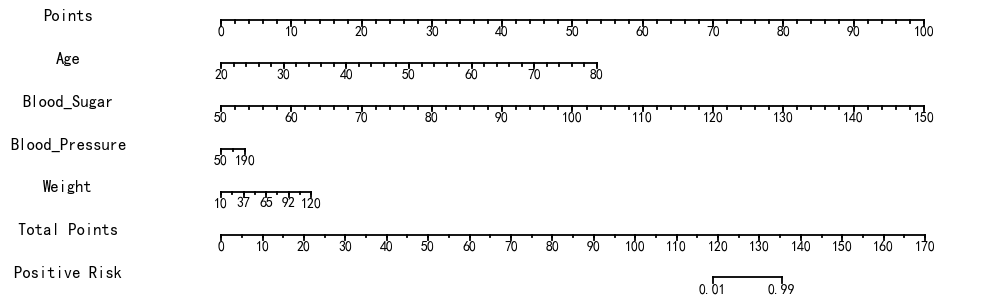

In [17]:
cmv_nomo = get_nomogram(param_df)
cmv_nomo.show()

## 显示差别分析

可以看到，上面的Points、Total Points以及最下面的概率线段都和R几乎完全一致，并在概率点位上的数值也一样，而其他线段和R的实现的数值结果也是相同的，之所以显示效果不同在于，R的[nomogram函数的源码](https://github.com/harrelfe/rms/blob/master/R/nomogram.s)中生成刻度使用了[pretty函数](https://github.com/wch/r-source/blob/trunk/src/library/base/R/pretty.R)，这个函数的效果如[这个例子](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/pretty)所示，它能将刻度转成更好看的区间形式。我尝试过对这个pretty进行复现，但是由于其底层还调用了R的.Interval函数，而这个是R语言中用于调用底层C函数的接口，因此复现起来非常困难，Python目前也没有类似的pretty函数的三方库，所以这里我只是根据自己的理解实现了上面的`adj_range`函数。这是stackoverflow论坛对此的[讨论](https://stackoverflow.com/questions/43075617/python-function-equivalent-to-rs-pretty)